# VAE Tutorial (Part 1)

Coming up:

1. Build and train an MLP based VAE with Jax and Haiku.
2. Explore reconstruction, sampling, and the latent space.

  a) At first with a latent dim of 2, then 10.

  b) Investigate tradeoffs.

3. Representation Learning with VAEs?

Step 3 is in a follow-up Colab [here](https://github.com/eemlcommunity/PracticalSessions2021/blob/main/generative/2_disentangling.ipynb).



## Setup and Helpers

In [2]:
#@title RUN this cell to install and import required libraries
!pip install -q git+https://github.com/deepmind/dm-haiku
!pip install -q dm-haiku optax

from typing import Any, Iterator, Iterable, Generator, Mapping, Tuple, NamedTuple, Sequence

from collections import defaultdict, namedtuple
# from absl import app
# from absl import flags
# from absl import logging
import haiku as hk
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import optax

import tensorflow.image
import tensorflow_datasets as tfds

import math
from pprint import pprint

import sklearn.manifold
import scipy.stats

import pandas as pd
import seaborn as sns

# import functools

# %matplotlib inline


     |████████████████████████████████| 122kB 3.9MB/s 
     |████████████████████████████████| 61kB 5.5MB/s 


In [3]:
#@title Python Type Declarations
OptState = Any
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]

CLASS_LABELS = [
    # -- FashionMNIST
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
    'Shirt', 'Sneaker', 'Bag', 'Ankle boot',
    # -- MNIST
    # 'zero', 'one', 'two', 'three', 'four', 'five', 'six',
    # 'seven', 'eight', 'nine'
]


In [4]:
#@title Dataset Loading and Visualization

DATA_SHUFFLE_LENGTH = 50  # In terms of batch_size.

def gallery(
    images, labels: Sequence[int] = None,
    max_images: int = 10, max_fig_size=(30, 30)):
  
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, max_images)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=max_fig_size,
                          subplot_kw={'xticks': [], 'yticks': []})
  if num_frames == 1:
    axes = [axes]

  # All outputs in the notebook are supposed to be between 0 and 1
  images = np.clip(images, 0.0, 1.0)
  
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    if labels is not None:
      axes[i].set_title(CLASS_LABELS[labels[i]], fontsize=28)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()


# Mnist and FashionMnist sizes:
TRAIN_SET_SIZE = 60000
TEST_SET_SIZE = 10000
MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterable[Batch]:
  # ds = tfds.load("mnist", split=split, shuffle_files=True)
  ds = tfds.load("fashion_mnist", split=split, shuffle_files=True)
  def normalize(inp):
    inp['image'] = tensorflow.image.convert_image_dtype(
        inp['image'], tensorflow.float32)
    return inp
  ds = ds.map(normalize)
  ds = ds.cache()  # Cache the normalized version
  ds = ds.repeat(2)  # To shuffle across epoch boundary.
  ds = ds.shuffle(
      buffer_size=DATA_SHUFFLE_LENGTH * batch_size)
  ds = ds.repeat()  # Forever.
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=5)
  return tfds.as_numpy(ds)


In [5]:
#@title subplots helper
def make_subplots(num_plots, max_cols, figwidth=12):
  if num_plots > max_cols:
    y = max_cols
    x = int(math.ceil(num_plots/y))
  else:
    x = 1
    y = num_plots
  figsize = (figwidth, figwidth/y*x)
  fig, axes = plt.subplots(x, y, figsize=figsize)

  # In all cases, make ax a flat list of axes.
  if num_plots == 1:
    return [axes]
  elif x == 1 or y == 1:
    return axes
  else:
    all_axes = []
    for axs in axes:
      all_axes.extend(axs)
    return all_axes[:num_plots]


## Load and Explore Data

Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJ4P0TZ/fashion_mnist-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteJ4P0TZ/fashion_mnist-test.tfrecord


Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


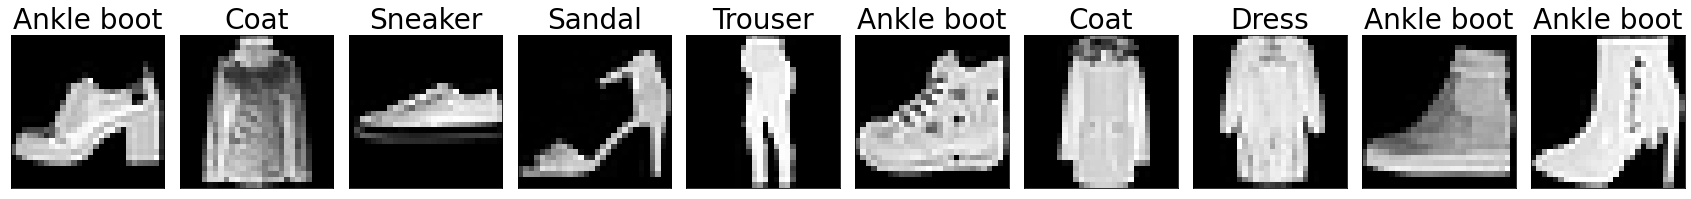

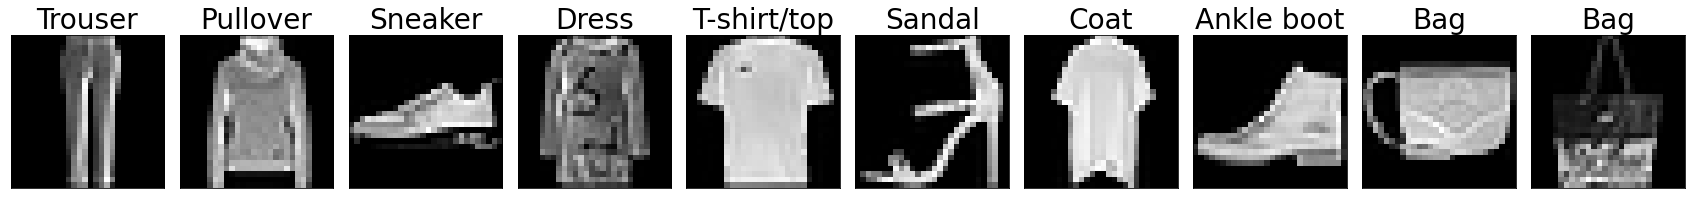

In [6]:
train_ds = iter(load_dataset(tfds.Split.TRAIN, 100))
batch = next(train_ds)

for i in range(0, 20, 10):
  gallery(batch['image'][i:i+10], batch['label'][i:i+10])


In [7]:
print('image shape:', batch['image'][0].shape)
print('image (min/mean/max):',
      [fn(batch['image'][0]) for fn in (np.min, np.mean, np.max)])
print('label shape:', batch['label'][0].shape)
print('label:', batch['label'][0])


image shape: (28, 28, 1)
image (min/mean/max): [0.0, 0.27731594, 1.0]
label shape: ()
label: 9


## Implement a VAE

Plan:

* Fashion MNIST dataset.
* Binarized data,
* Modeled with Bernoulli distribution over pixels. (alternatives) 
* Small MLP architecture.
* Usually latent of dim 10, at first dim 2.


## The MLP Model (V1)

At first we only implement a an encoder and a decoder, make sure that works, then move on to add more features.

In [8]:
class MlpVAE():

  def __init__(
      self,
      num_linear_units: Sequence[int],
      latent_size: int,
      output_shape: Sequence[int],    # Not including batch dim.
      ):
    """An MLP VAE architecture.

    The encoder is a sequence of linear (fully connected) layers, with the 
    specified number of units. This then linearly map into a mean and stddev
    vector to parametrize Gaussians over the latent space. The decoder is the
    "inversion" of the sequence of linear encoder layers.

    Both the encoder and the decoder uses ReLU throughout.
    """
    self._latent_size = latent_size
    self._num_linear_units = num_linear_units
    self._output_shape = output_shape
    self._output_units = np.prod(np.array(output_shape))
    
  def _get_gaussian_params(self, x):
    """Maps to the mean and stddev of a guassian over the latent space."""
    # Linear layers act only on the last axis, so flatten the data first.
    x = hk.Flatten()(x)

    for idx, num_units in enumerate(self._num_linear_units):
      x = hk.Linear(num_units, name=f"encode_fc_{idx}")(x)
      x = jax.nn.relu(x)
    
    mean = hk.Linear(self._latent_size, name=f"encode_fc_mean")(x)
    log_stddev = hk.Linear(self._latent_size, name=f"encode_fc_stddev")(x)
    stddev = jnp.exp(log_stddev)   # Could also use softplus: log(1+e^x).
    return mean, stddev

  def encode(self, x):
    """Returns (z_sample, (mean, var))."""
    # Sample from N(0, 1), and scale and shift the distribution to make
    # it distributed according to N(mean, stddev^2).
    mean, stddev = self._get_gaussian_params(x)
    normal_sample = jax.random.normal(hk.next_rng_key(), mean.shape)
    z = mean + stddev * normal_sample
    return z, (mean, stddev)

  def _get_logits(self, z):
    """Returns the "logits" for a pixel-wise bernoulli distr over the image."""
    x = z
    for idx, num_units in enumerate(reversed(self._num_linear_units)):
      x = hk.Linear(num_units, name=f"decode_fc_{idx}")(x)
      x = jax.nn.relu(x)

    x = hk.Linear(self._output_units, name=f"decode_fc_last")(x)
    return hk.Reshape(self._output_shape)(x)

  def decode(self, z):
    """Returns a pixel-wise bernoulli distribution over the image space."""
    logits = self._get_logits(z)
    # Apply sigmoid to bring to [0, 1]-range.
    mean_image = jax.nn.sigmoid(logits)
    sampled_image = jax.random.bernoulli(hk.next_rng_key(), mean_image)
    return mean_image, (logits, sampled_image)


#### Checks on the model

Make sure it's runnable, shapes and ranges are correct, can be jitted.

In [9]:
def vae():
  vae = MlpVAE(
      num_linear_units=(2000, 1600),
      latent_size=2,
      output_shape=MNIST_IMAGE_SHAPE,
  )

  def init(x):
    z, (mean, stddev) = vae.encode(x)
    return vae.decode(z)

  return init, (vae.encode, vae.decode)

vae = hk.multi_transform(vae)
rng_key = jax.random.PRNGKey(42)
x = jnp.ones((10,) + MNIST_IMAGE_SHAPE)  # Batch of 10.

rng_key, rng_subkey = jax.random.split(rng_key)
params = vae.init(rng_subkey, x)
print(jax.tree_map(jnp.shape, params))

vae_encode, vae_decode = vae.apply

FlatMap({
  'decode_fc_0': FlatMap({'b': (1600,), 'w': (2, 1600)}),
  'decode_fc_1': FlatMap({'b': (2000,), 'w': (1600, 2000)}),
  'decode_fc_last': FlatMap({'b': (784,), 'w': (2000, 784)}),
  'encode_fc_0': FlatMap({'b': (2000,), 'w': (784, 2000)}),
  'encode_fc_1': FlatMap({'b': (1600,), 'w': (2000, 1600)}),
  'encode_fc_mean': FlatMap({'b': (2,), 'w': (1600, 2)}),
  'encode_fc_stddev': FlatMap({'b': (2,), 'w': (1600, 2)}),
})


In [10]:
def test_it(batch_size, rng_key):
  rng_key, rng_subkey = jax.random.split(rng_key)
  z, _ = vae_encode(params, rng_subkey, jnp.ones((batch_size,) + MNIST_IMAGE_SHAPE))
  rng_key, rng_subkey = jax.random.split(rng_key)
  y, _ = vae_decode(params, rng_subkey, z)
  print(y.shape)
  return rng_key

rng_key = test_it(3, rng_key)

(3, 28, 28, 1)


In [11]:
fast_test_it = jax.jit(test_it, static_argnums=0)
rng_key = fast_test_it(4, rng_key)

(4, 28, 28, 1)


## The MLP Model V2

Includes reconstruct and sample functions.

In [12]:
RecOutput = namedtuple(
    'RecOutput',
    ['mean_image', 'sampled_image', 'logits', 'z', 'mean', 'stddev']
)

VaeApply = namedtuple(
    'VaeApply',
    ['encode', 'decode', 'reconstruct', 'sample']
)


class MlpVAE():

  def __init__(
      self,
      num_linear_units: Sequence[int],
      latent_size: int,
      output_shape: Sequence[int]):  # Not including batch dim.
    """An MLP VAE architecture.

    The encoder is a sequence of linear (fully connected) layers, with the 
    specified number of units. This then linearly map into a mean and stddev
    vector to parametrize Gaussians over the latent space. The decoder is the
    "inversion" of the sequence of linear encoder layers.

    Both the encoder and the decoder uses ReLU throughout.
    """
    self._latent_size = latent_size
    self._num_linear_units = num_linear_units
    self._output_shape = output_shape
    self._output_units = np.prod(np.array(output_shape))
    
  def _get_gaussian_params(self, x):
    """Maps to the mean and stddev of a guassian over the latent space."""
    # Linear layers act only on the last axis, so flatten the data first.
    x = hk.Flatten()(x)

    for idx, num_units in enumerate(self._num_linear_units):
      x = hk.Linear(num_units, name=f"encode_fc_{idx}")(x)
      x = jax.nn.relu(x)
    
    mean = hk.Linear(self._latent_size, name=f"encode_fc_mean")(x)
    log_stddev = hk.Linear(self._latent_size, name=f"encode_fc_stddev")(x)
    stddev = jnp.exp(log_stddev)   # Could also use softplus: log(1+e^x).
    return mean, stddev

  def encode(self, x):
    """Returns (z_sample, (mean, var))."""
    # Sample from N(0, 1), and scale and shift the distribution to make
    # it distributed according to N(mean, stddev^2).
    mean, stddev = self._get_gaussian_params(x)
    normal_sample = jax.random.normal(hk.next_rng_key(), mean.shape)
    z = mean + stddev * normal_sample
    return z, (mean, stddev)

  def _get_logits(self, z):
    """Returns the "logits" for a pixel-wise bernoulli distr over the image."""
    x = z
    for idx, num_units in enumerate(reversed(self._num_linear_units)):
      x = hk.Linear(num_units, name=f"decode_fc_{idx}")(x)
      x = jax.nn.relu(x)

    x = hk.Linear(self._output_units, name=f"decode_fc_last")(x)
    return hk.Reshape(self._output_shape)(x)

  def decode(self, z):
    """Returns a pixel-wise bernoulli distribution over the image space."""
    logits = self._get_logits(z)
    # Apply sigmoid to bring to [0, 1]-range.
    mean_image = jax.nn.sigmoid(logits)
    sampled_image = jax.random.bernoulli(hk.next_rng_key(), mean_image)
    return mean_image, (logits, sampled_image)

  def reconstruct(self, x):
    """A sampled reconstruction; returns a `RecOutput`."""
    z, (mean, stddev) = self.encode(x)
    mean_image, (logits, sampled_image) = self.decode(z)
    return RecOutput(mean_image, sampled_image, logits, z, mean, stddev)

  def sample(self, num_samples):
    """Sample from the learnt distribution -- decode samples from the prior."""
    sampled_z = jax.random.normal(
        hk.next_rng_key(), (num_samples, self._latent_size))
    return self.decode(sampled_z)


#### Make and Check the Model

In [13]:
def vae_fn_2latents():
  vae = MlpVAE(
      num_linear_units=(2000, 1600),
      latent_size=2,
      output_shape=MNIST_IMAGE_SHAPE,
  )

  def init(x):
    return vae.reconstruct(x)

  return init, VaeApply(vae.encode, vae.decode, vae.reconstruct, vae.sample)

vae = hk.multi_transform(vae_fn_2latents)
rng_key = jax.random.PRNGKey(42)
x = jnp.ones((10,) + MNIST_IMAGE_SHAPE)  # Batch of 10.

rng_key, rng_subkey = jax.random.split(rng_key)
test_params = vae.init(rng_subkey, x)
print(jax.tree_map(jnp.shape, test_params))

FlatMap({
  'decode_fc_0': FlatMap({'b': (1600,), 'w': (2, 1600)}),
  'decode_fc_1': FlatMap({'b': (2000,), 'w': (1600, 2000)}),
  'decode_fc_last': FlatMap({'b': (784,), 'w': (2000, 784)}),
  'encode_fc_0': FlatMap({'b': (2000,), 'w': (784, 2000)}),
  'encode_fc_1': FlatMap({'b': (1600,), 'w': (2000, 1600)}),
  'encode_fc_mean': FlatMap({'b': (2,), 'w': (1600, 2)}),
  'encode_fc_stddev': FlatMap({'b': (2,), 'w': (1600, 2)}),
})


In [14]:
def test_it(batch_size, rng_key):
  rng_key, rng_subkey = jax.random.split(rng_key)
  result = vae.apply.reconstruct(
      test_params, rng_subkey, jnp.ones((batch_size,) + MNIST_IMAGE_SHAPE)
  )
  print(result.mean_image.shape)
  return rng_key

rng_key = test_it(3, rng_key)

(3, 28, 28, 1)


In [15]:
fast_test_it = jax.jit(test_it, static_argnums=0)
rng_key = fast_test_it(4, rng_key)

(4, 28, 28, 1)


We have a function, `vae_fn_2latents`, to make a VAE with a latent dim of 2. Let's also make one with a dim of 10.

In [16]:
def vae_fn_10latents():
  vae = MlpVAE(
      num_linear_units=(2000, 1600),
      latent_size=10,
      output_shape=MNIST_IMAGE_SHAPE,
  )

  def init(x):
    return vae.reconstruct(x)

  return init, VaeApply(vae.encode, vae.decode, vae.reconstruct, vae.sample)


## ELBO

Recall that we want to maximize the Evidence Lower Bound (ELBO):

<font size=4>
<br>
$$ \mathcal{L}(x) = \mathbb{E}_{z \sim q_\phi(z|x)} \big[\log p_\theta(x | z)\big] - \mathbb{KL}\big(q_\phi(z | x) || p(z)\big).$$
</font>
<br>

Here

* $q_\phi(z|x)$ is the Gaussian posterior; the inferred latent distribution corresponding to the input $x$,
* $p_\theta(x|z)$ is the likelihood of $x$ for latent $z$ according to our model,
* $p(z)$ is our chosen prior, $\mathcal{N}(0, I)$, the centered unit variance gaussian.

The above expression uses an expectation; in practice we will take a sample to approximate the expectation.




**The KL for our Gaussian $q_\phi(z|x)$ and prior**

The KL between two Gaussians can be computed analytically! Furthermore, since the components of our multivariate Gaussians are independent, we can make the calculation component-wise then sum. 

With derivations, or from a reference, we find:

$$ \mathbb{KL}\big( \mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1) \big) = \frac12 \big(\sigma^2  - \log(\sigma^2) + \mu^2 - 1 \big).$$




In [17]:
def kl_gaussian(mean: jnp.ndarray, variance: jnp.ndarray) -> jnp.ndarray:
  """Calculate KL between a given and standard gaussian distributions."""
  kl_divergence_vector = 0.5 * (-jnp.log(variance) - 1.0 + variance + mean**2)
  return jnp.sum(kl_divergence_vector, axis=-1)  # Sum over latent dimensions.

# Sanity checks:
# u=0, sigma=1 --> same distribution --> 0 KL
# u=100000, sigma=0.01 --> nearly separate support --> close to inf KL
mean_vectors = jnp.array([
    [0.0, 0.0],  # Example 1.
    [100000, 100000],  # Example 2.
])
variance = jnp.array([
    [1, 1],  # Example 1.
    [0.1, 0.1],  # Example 2.
])

kl_gaussian(mean_vectors, variance)

DeviceArray([0.e+00, 1.e+10], dtype=float32)

In [18]:
def binary_cross_entropy(x: jnp.ndarray, logits: jnp.ndarray) -> jnp.ndarray:
  """Calculate binary (logistic) cross-entropy from distribution logits.

  Args:
    x: input variable tensor, must be of same shape as logits
    logits: log odds of a Bernoulli distribution, i.e. log(p/(1-p))
  Returns:
    A batch of scalars representing binary CE for the given Bernoulli
    distribution.
  """
  if x.shape != logits.shape:
    raise ValueError("inputs x and logits must be of the same shape")

  x = jnp.reshape(x, (x.shape[0], -1))
  logits = jnp.reshape(logits, (logits.shape[0], -1))

  # Use logaddexp(x1, x2) for numerically good "log(exp(x1) + exp(x2))"
  return -jnp.sum(x * logits - jnp.logaddexp(0.0, logits), axis=-1)


In [19]:
def elbo(x: jnp.ndarray, logits: jnp.ndarray, 
         mean: jnp.ndarray, stddev: jnp.ndarray) -> jnp.ndarray:
    """Calculate the ELBO.
    
    Args:
      x: data whose likelihood we are interested in.
      logits: the logodds (logits) of the decoded distribution from the model.
      mean: mean of the q(z|x).
      stddev: stddev of the q(z|x).
 
    Returns:
      The ELBO, log_likelihood and kl averaged over the batch.
    """
    log_likelihood = -binary_cross_entropy(x, logits)
    kl = kl_gaussian(mean, stddev**2)
    elbo = log_likelihood - kl

    return jnp.mean(elbo), jnp.mean(log_likelihood), jnp.mean(kl)

## Training (dim=2)




EPOCH: 0; Train elbo (-loss): None;Validation elbo (-loss): -552.629150390625


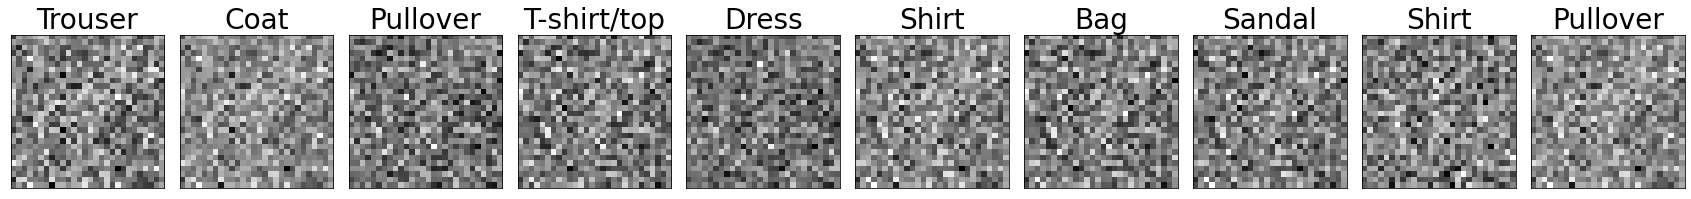

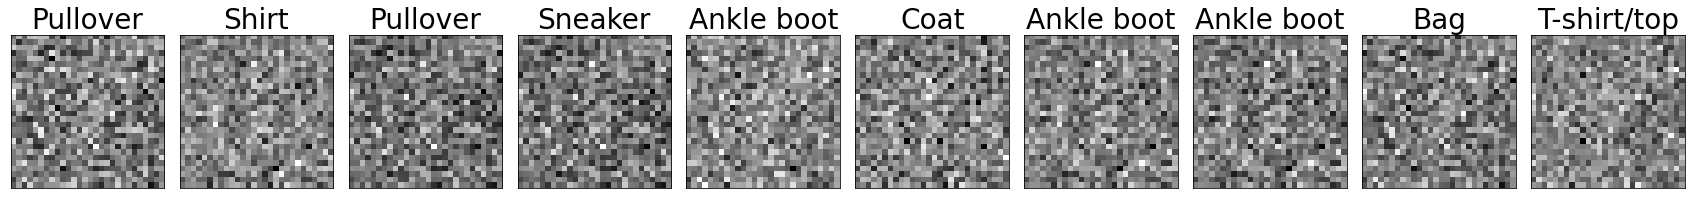



EPOCH: 1; Train elbo (-loss): -298.7691345214844;Validation elbo (-loss): -283.7406311035156


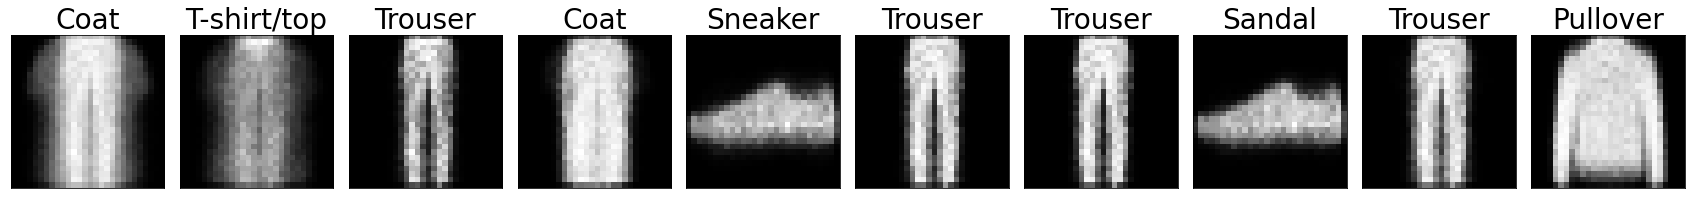

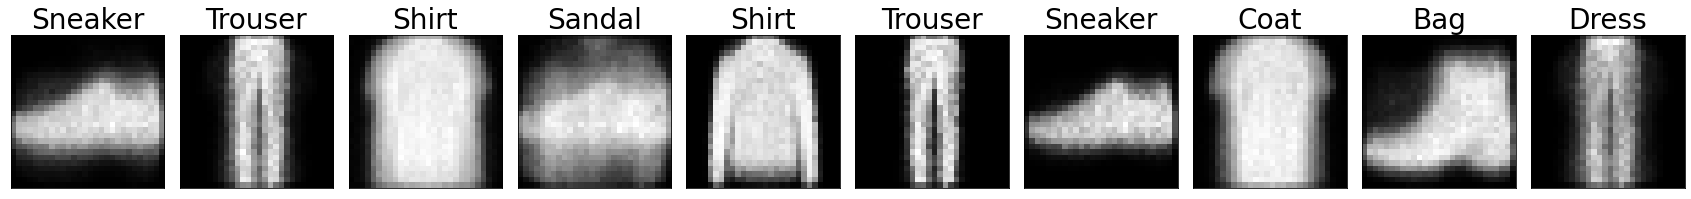



EPOCH: 2; Train elbo (-loss): -278.6543273925781;Validation elbo (-loss): -278.03125


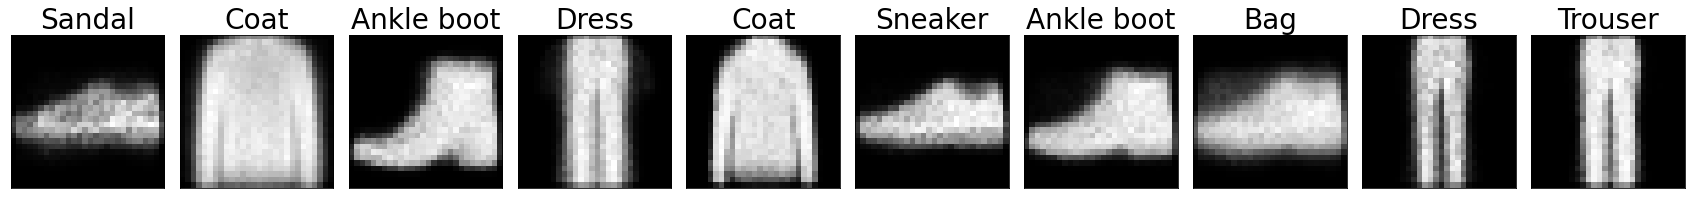

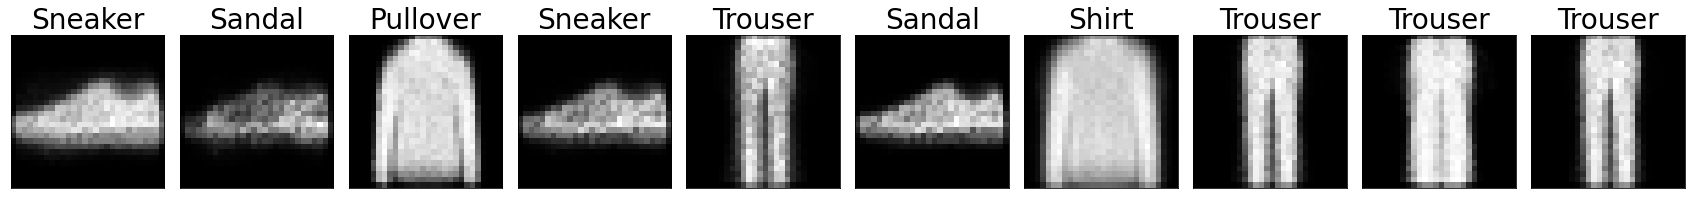



EPOCH: 3; Train elbo (-loss): -273.802001953125;Validation elbo (-loss): -272.1508483886719


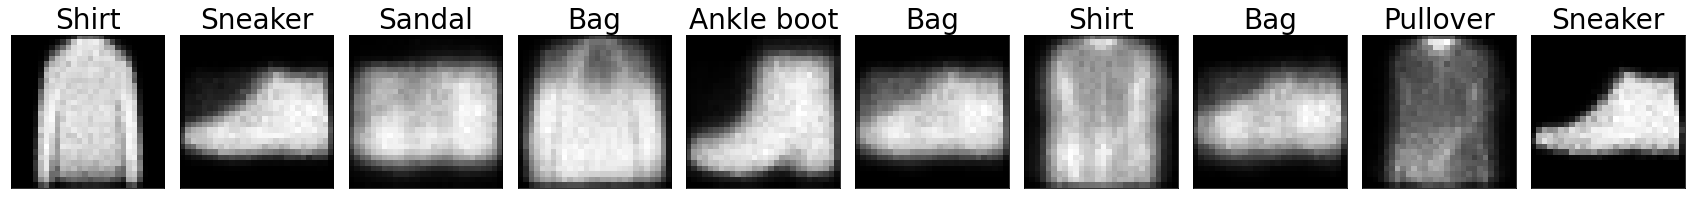

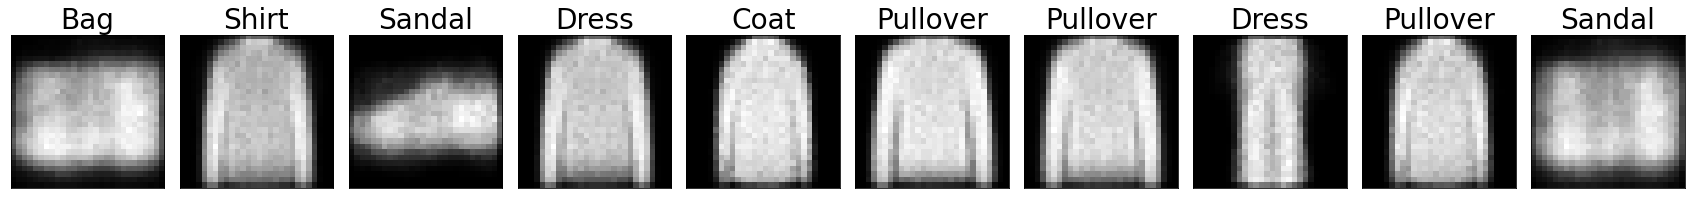



EPOCH: 4; Train elbo (-loss): -270.6575622558594;Validation elbo (-loss): -269.7062072753906


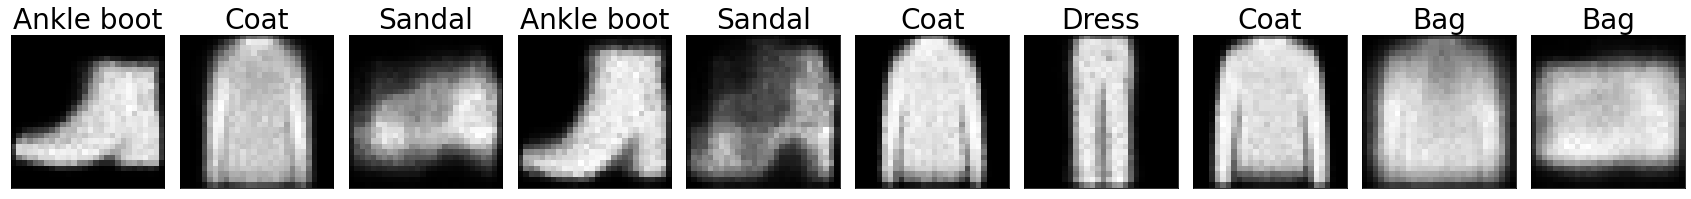

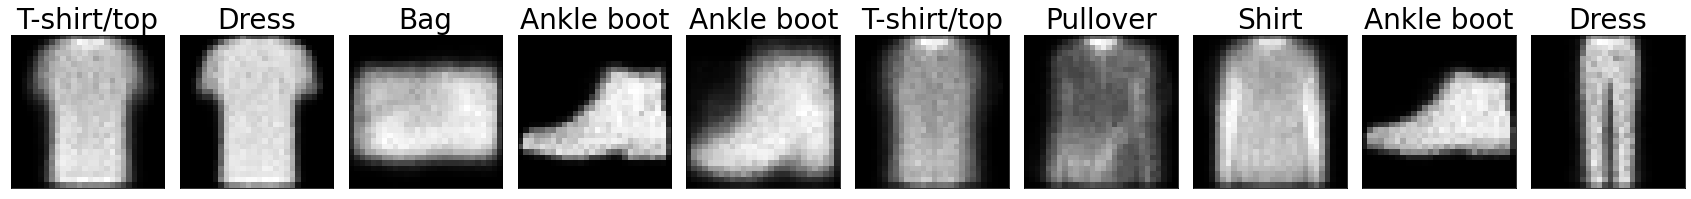



EPOCH: 5; Train elbo (-loss): -268.10833740234375;Validation elbo (-loss): -269.9488830566406


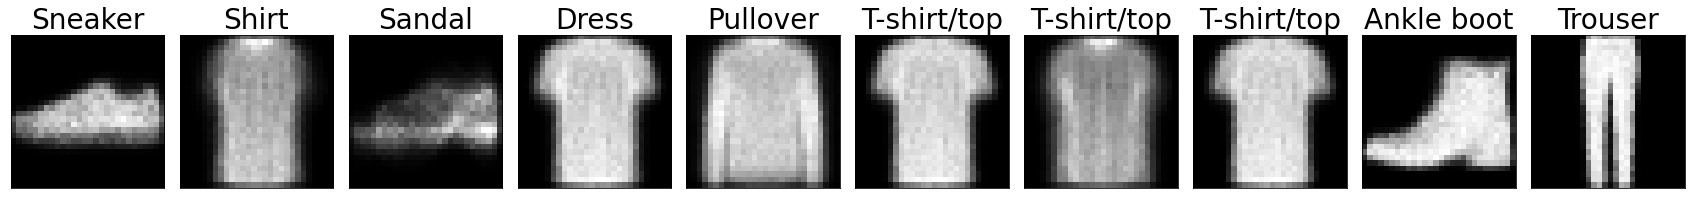

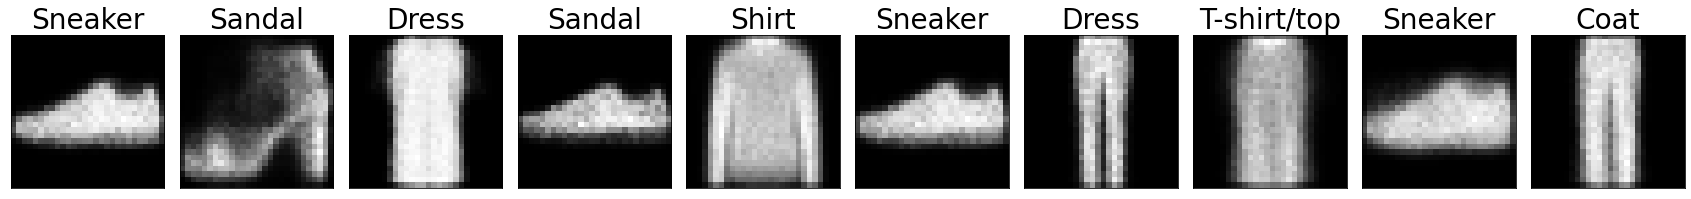

In [20]:
def train(vae_fn, num_epochs=15):
  """Full training.

  Args:
    vae_fn: the function to hk.multi_transform.
  """
  batch_size = 128

  train_ds = iter(load_dataset(tfds.Split.TRAIN, batch_size))
  valid_all_ds = iter(load_dataset(tfds.Split.TEST, TEST_SET_SIZE))
  # IMPORTANT! Normally you would use a different validation and test set;
  # This dataset does not have an explicit VALIDATION split; some of the
  # training set should be set aside for this.

  rng_seq = hk.PRNGSequence(42)
  optimizer = optax.adam(1e-4)
  vae = hk.multi_transform(vae_fn)
  params = vae.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
  opt_state = optimizer.init(params)


  @jax.jit
  def elbo_fn(params: hk.Params, rng_key: PRNGKey, batch: Batch) -> jnp.ndarray:
      """Return ELBO and its components"""
      images = batch["image"]
      output = vae.apply.reconstruct(params, rng_key, images)
      return elbo(images, output.logits, output.mean, output.stddev)


  @jax.jit
  def update(
      params: hk.Params, rng_key: PRNGKey, opt_state: OptState,  batch: Batch
  ) -> Tuple[hk.Params, OptState]:
    """Single update step."""
    def _just_loss(params, rng_key, batch):
      # NOTE the negative on the elbo!
      return -elbo_fn(params, rng_key, batch)[0]

    grads = jax.grad(_just_loss)(params, rng_key, batch)
    elbo, ll, kl = elbo_fn(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, elbo, ll, kl


  training_stats = defaultdict(list)
  for epoch in range(num_epochs+1):

    if epoch > 0:
      # Collect stats on an untrained model, so do not train.
      elbs, lls, kls = [], [], []
      for _ in range(TRAIN_SET_SIZE // batch_size):
        batch = next(train_ds)
        # Binarize like in https://github.com/google/jax/blob/master/examples/mnist_vae.py
        batch['image'] = jax.random.bernoulli(
            next(rng_seq), batch['image'])
        params, opt_state, elb, ll, kl = update(
            params, next(rng_seq), opt_state, batch)
        elbs.append(elb)
        lls.append(ll)
        kls.append(kl)
      
      elb = np.array(elbs).mean()
      ll = np.array(lls).mean()
      kl = np.array(kls).mean()
    else:
      elb, ll, kl = None, None, None
  
    valid_all = next(valid_all_ds)
    valid_all['image'] = jax.random.bernoulli(
        next(rng_seq), valid_all['image'])
    val_elb, val_ll, val_kl = elbo_fn(
        params, next(rng_seq), valid_all)
    print("\n")
    print(f"EPOCH: {epoch}; Train elbo (-loss): {elb};"
          f"Validation elbo (-loss): {val_elb}")
    
    training_stats['val_elbo'].append(val_elb)
    training_stats['train_elbo'].append(elb)
    training_stats['val_kl'].append(val_kl)
    training_stats['train_kl'].append(kl)
    training_stats['val_ll'].append(val_ll)
    training_stats['train_ll'].append(ll)
    training_stats['epoch'].append(epoch)

    valid_output = vae.apply.reconstruct(
        params, next(rng_seq), valid_all["image"])
    # gallery(valid_all["image"], valid_all['label'])
    gallery(valid_output.mean_image, valid_all['label'])
    gallery(valid_output.mean_image[10:], valid_all['label'][10:])
  return vae, params, training_stats

vae2, params2, training_stats2 = train(
    vae_fn_2latents, num_epochs=5)

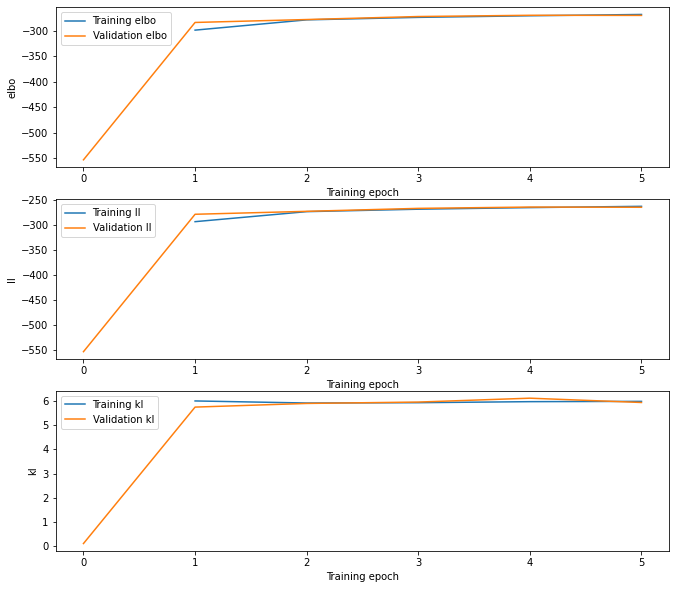

In [21]:
#@title Training Curves

def plot_stats(
    training_stats, use_first=False, figsize=(11, 10)):
  from_idx = 0 if use_first else 1
  f, ax = plt.subplots(3, 1, figsize=figsize)
  for key, axx in zip(['elbo', 'll', 'kl'], ax.reshape(-1,)):
    axx.plot(
        training_stats['epoch'][from_idx:],
        training_stats[f'train_{key}'][from_idx:],
        label=f"Training {key}")
    axx.plot(
        training_stats['epoch'][from_idx:],
        training_stats[f'val_{key}'][from_idx:],
        label=f"Validation {key}")
    axx.set_xlabel("Training epoch")
    axx.set_ylabel(key)
    axx.legend()
  
plot_stats(training_stats2, use_first=True)

Visualizing reconstructions from the training and validation sets.

In [22]:
rng_seq = hk.PRNGSequence(42)

a_batch_size = 128
a_train_ds = iter(load_dataset(tfds.Split.TRAIN, a_batch_size))
a_valid_ds = iter(load_dataset(tfds.Split.TEST, a_batch_size))

In [23]:
def see_reconstructions(vae_model, vae_params, viz_type: str, rng_seq):
  """
  Args:
    vae_model: the transformed model,
    vae_params: the (trained) params for the model,
    viz_type: one of "mean_image", "sampled_image",
    rng_seq: haiku sequence, for randomness.
  """
  train_batch_viz = next(a_train_ds)
  valid_batch_viz = next(a_valid_ds)
  train_original_image = train_batch_viz['image']
  valid_original_image = valid_batch_viz['image']
  train_batch_viz['image'] = jax.random.bernoulli(
      next(rng_seq), train_batch_viz['image'])
  valid_batch_viz['image'] = jax.random.bernoulli(
      next(rng_seq), valid_batch_viz['image'])

  print("Train original then reconstruction under it:")
  output = vae_model.apply.reconstruct(
      vae_params, next(rng_seq), train_batch_viz["image"])
  train_img = train_original_image if visualize == 'mean_image' else train_batch_viz['image']
  gallery(train_img, train_batch_viz['label'])
  gallery(getattr(output, visualize))
  gallery(train_img[10:], train_batch_viz['label'][10:])
  gallery(getattr(output, visualize)[10:])

  print("Validation original then reconstruction under it:")
  output = vae_model.apply.reconstruct(
      vae_params, next(rng_seq), valid_batch_viz["image"])
  valid_img = valid_original_image if visualize == 'mean_image' else valid_batch_viz['image']
  gallery(valid_img, valid_batch_viz['label'])
  gallery(getattr(output, visualize))
  gallery(valid_img[10:], valid_batch_viz['label'][10:])
  gallery(getattr(output, visualize)[10:])


Train original then reconstruction under it:


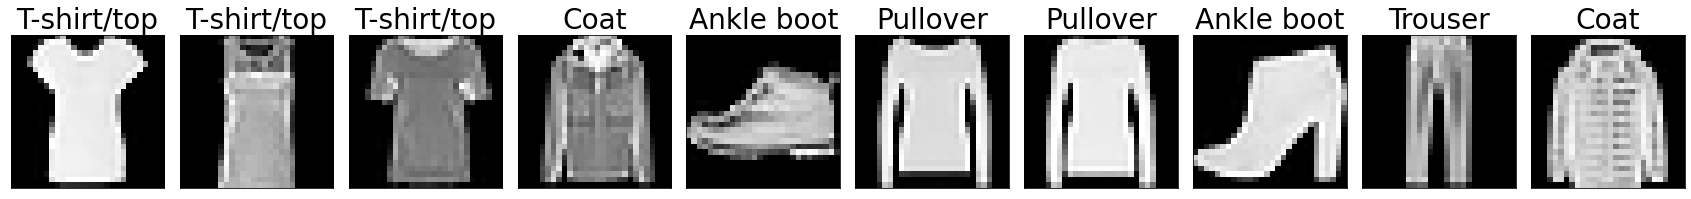

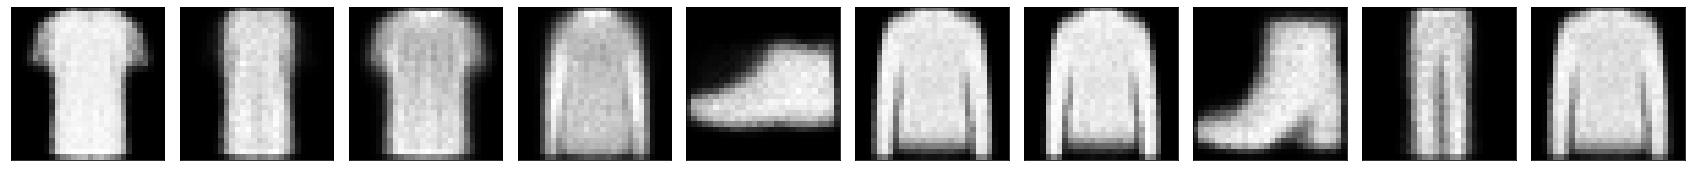

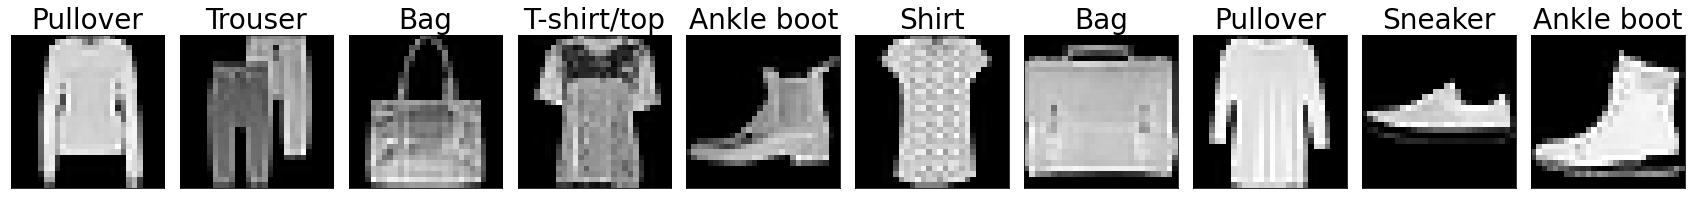

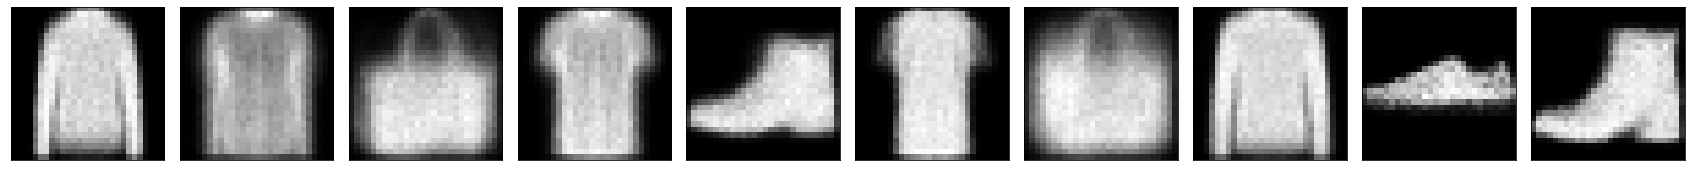

Validation original then reconstruction under it:


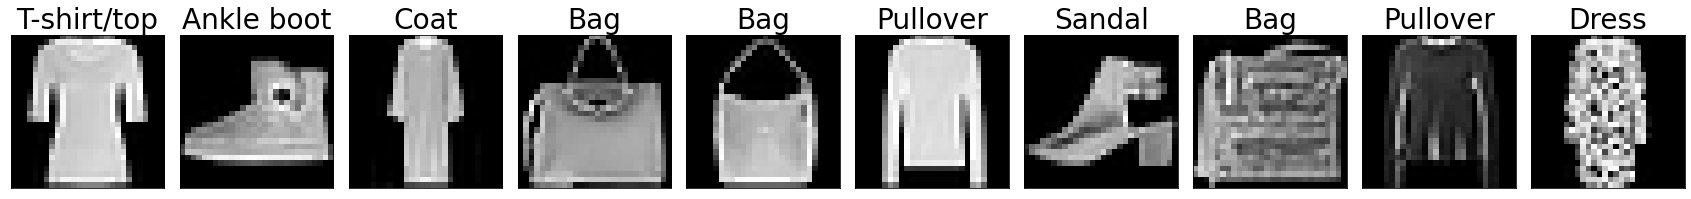

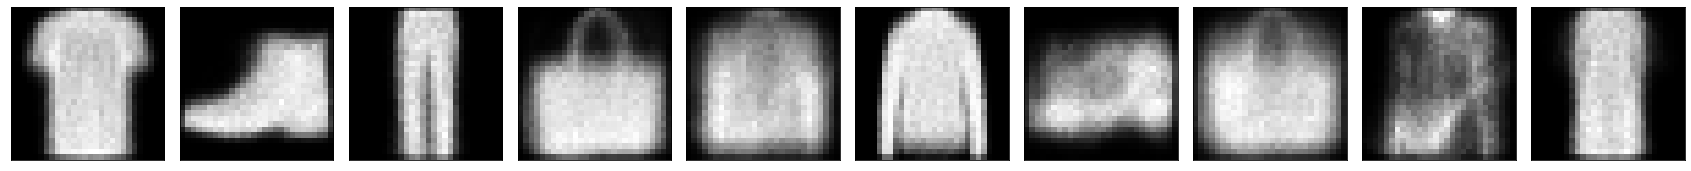

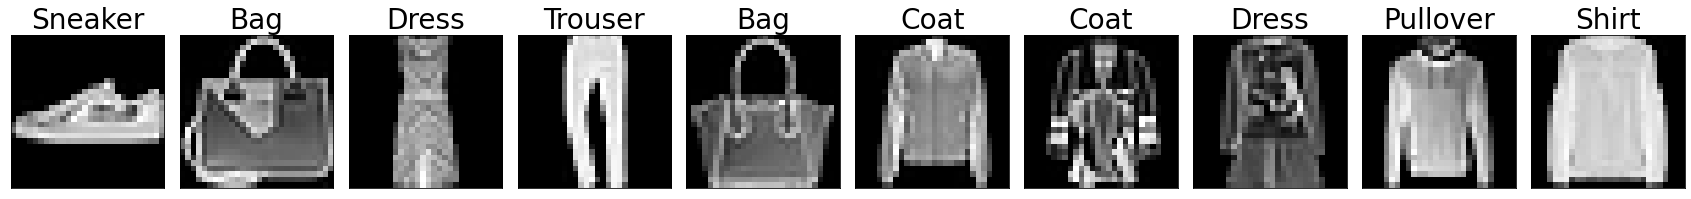

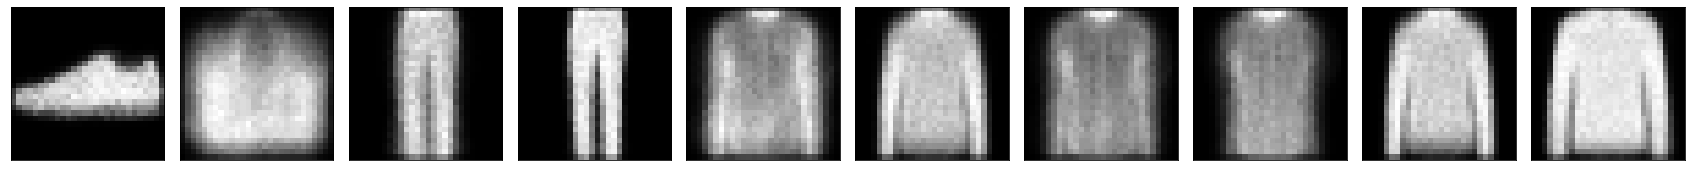

In [24]:
#@title Reconstructions { run: "auto" }
visualize = 'mean_image' #@param ["mean_image", "sampled_image"] 

see_reconstructions(vae2, params2, visualize, rng_seq)


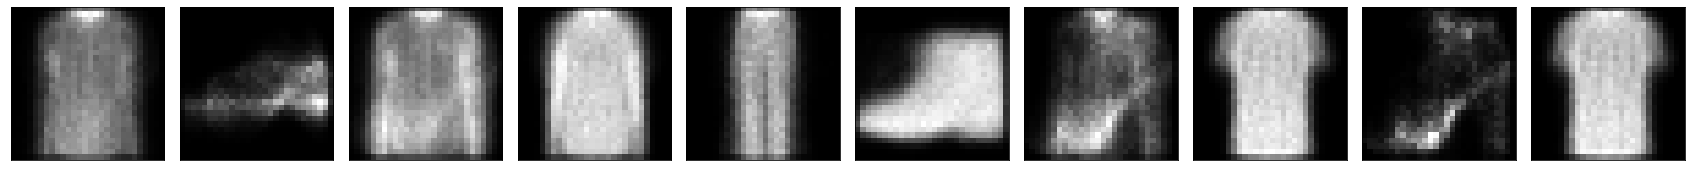

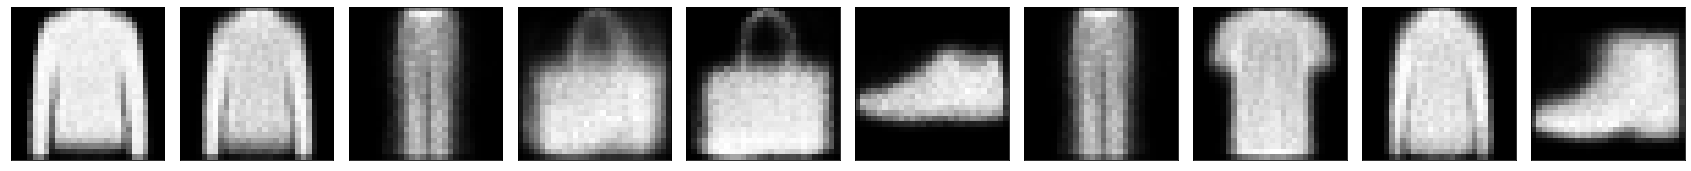

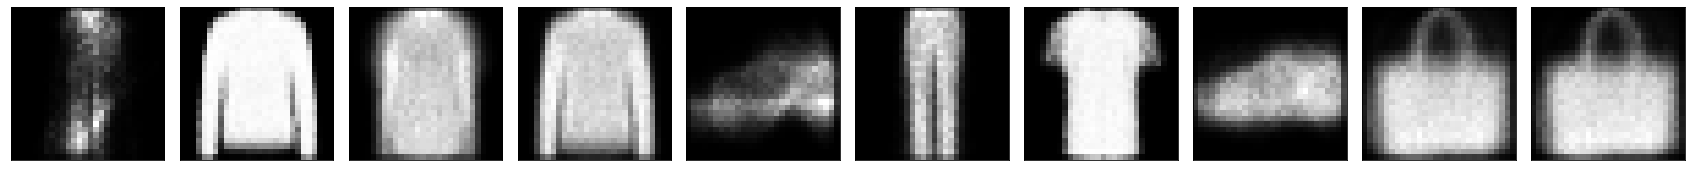

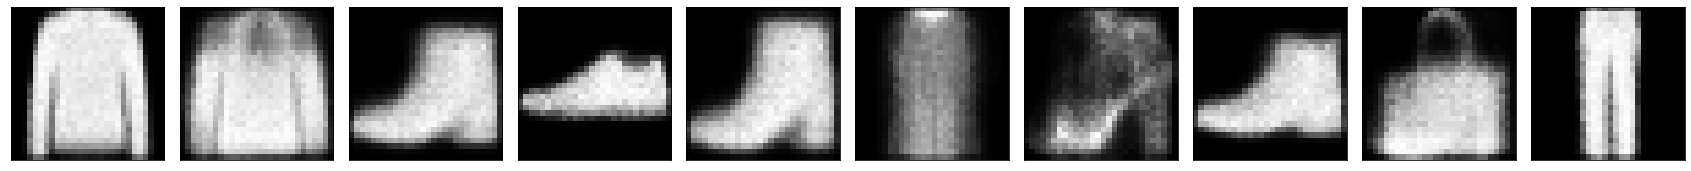

In [25]:
#@title Samples
mean_image, _ = vae2.apply.sample(params2, next(rng_seq), 40)
for i in range(4):
  gallery(mean_image[(i*10):])


How could you evaluate how well the distribution of data is learnt? (Recall, our sampling distribution is meant to be the same as the data distribution.)



## Latent Space Exploration

We encode examples from the validation set and collect a sample from each posterior distribution. We can then plot these to see the structure of the latent space.

We colour the latents by their class. This is not information the model had, but it helps us interpret the space.


In [26]:
def get_latents(vae, params, dataset, num_batches=50):
  zs, z_means, z_stddevs, labels = [], [], [], []
  for _ in range(num_batches):
    batch = next(dataset)
    rec_output = vae.apply.reconstruct(
        params, next(rng_seq), batch["image"])
    zs.append(rec_output.z)
    z_means.append(rec_output.mean)
    z_stddevs.append(rec_output.stddev)
    labels.append(batch['label'])

  zs = np.concatenate(zs, axis=0)
  z_means = np.concatenate(z_means, axis=0)
  z_stddevs = np.concatenate(z_stddevs, axis=0)
  labels = np.concatenate(labels, axis=0)
  return zs, z_means, z_stddevs, labels

zs, z_means, z_stddevs, labels = get_latents(
    vae2, params2, a_valid_ds)
latent_dim = z_means.shape[-1]

z_means.shape

(6400, 2)

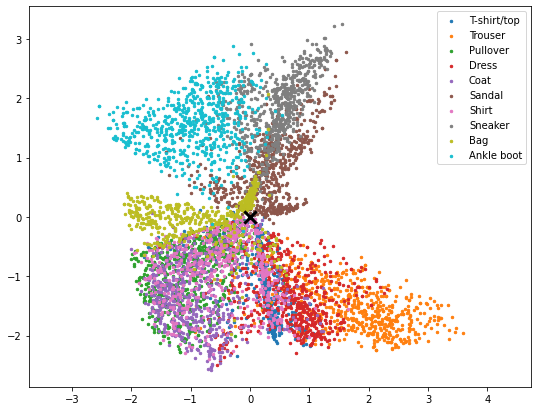

In [27]:
#@title 2D latent space {run: "auto"}
visualize = 'mean_z' #@param ["mean_z", "sampled_z"] 

if visualize == "mean_z":
  latents = z_means
elif visualize == "sampled_z":
  latents = zs


plt.figure(figsize=(9, 7))
for yy in range(10):
  plt.scatter(
      latents[labels==yy][:, 0],
      latents[labels==yy][:, 1],
      label=CLASS_LABELS[yy], s=6)
plt.legend()

plt.scatter(
    [0],[0], marker="x", s=150,
    color="black", linewidth=3)
plt.axis('equal');

What can you deduce about

* reconstruction,
* sampling

based on this visualization? Can you now better answer how well we learnt the data distribution?

## Training (dim=10)




EPOCH: 0; Train elbo (-loss): None;Validation elbo (-loss): -555.0244140625


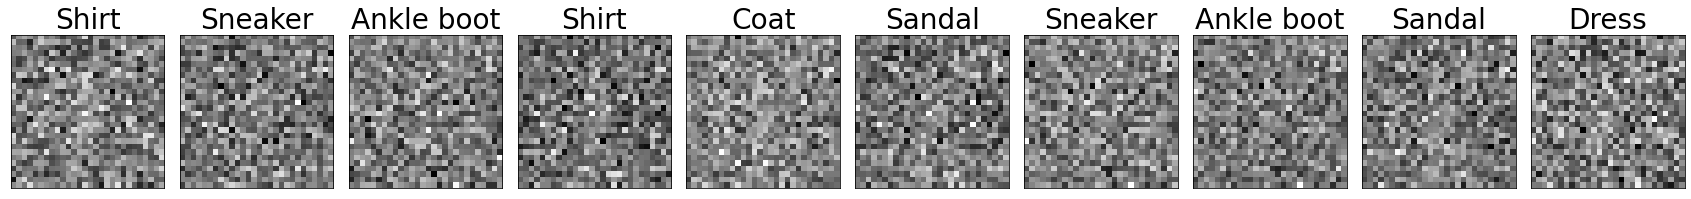

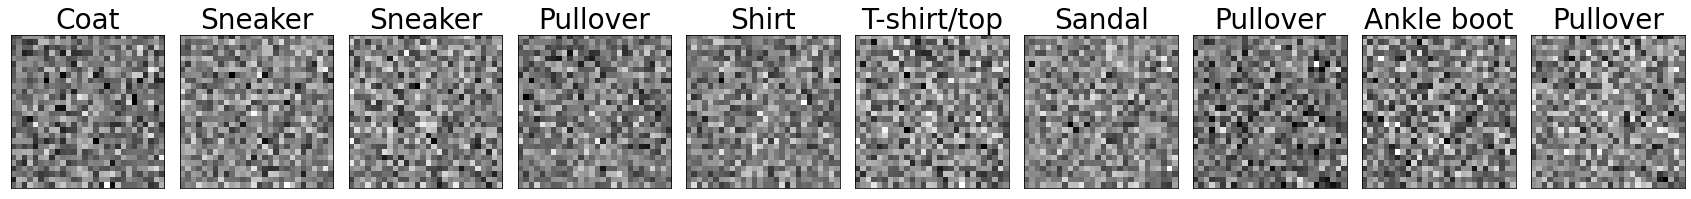



EPOCH: 1; Train elbo (-loss): -286.63287353515625;Validation elbo (-loss): -258.2030334472656


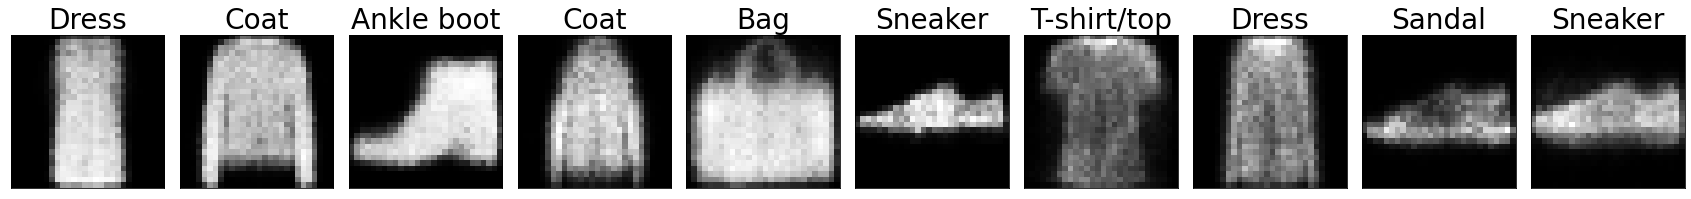

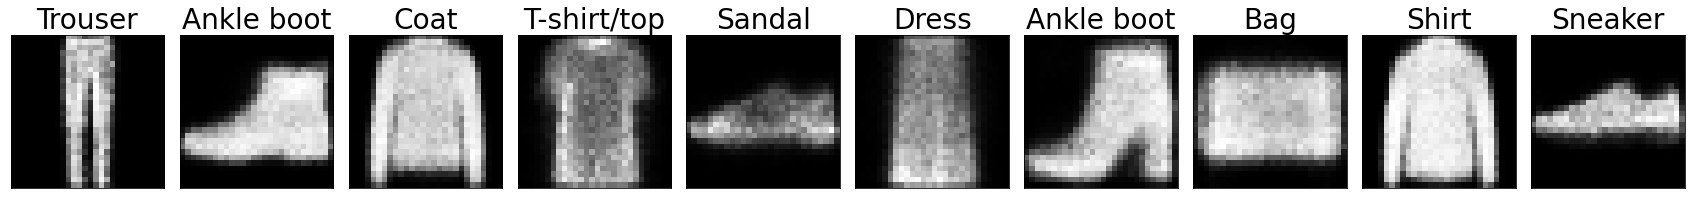



EPOCH: 2; Train elbo (-loss): -252.05809020996094;Validation elbo (-loss): -251.1013946533203


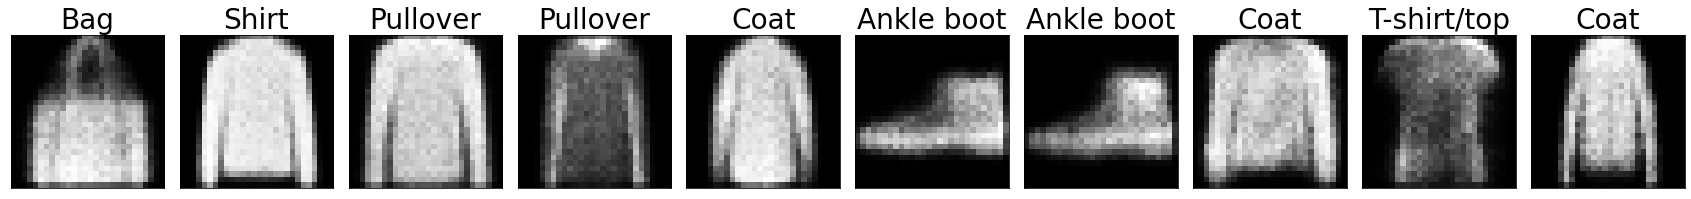

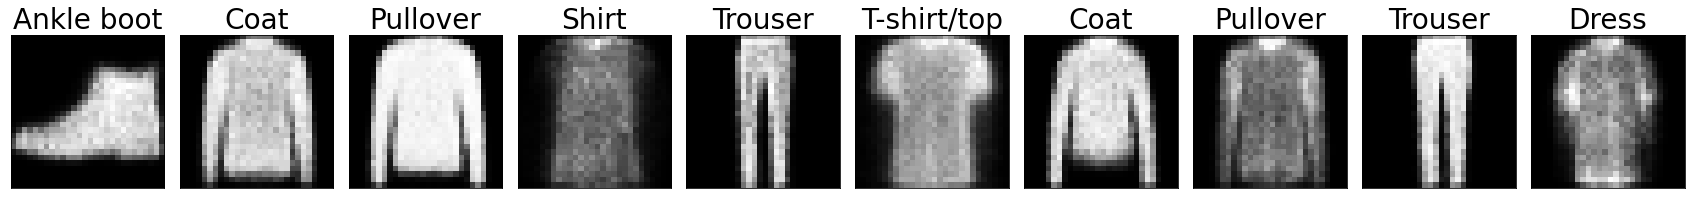



EPOCH: 3; Train elbo (-loss): -247.556396484375;Validation elbo (-loss): -247.7648468017578


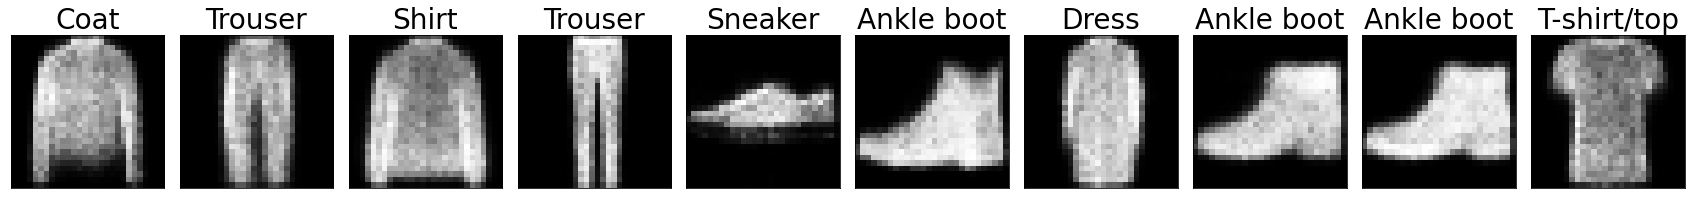

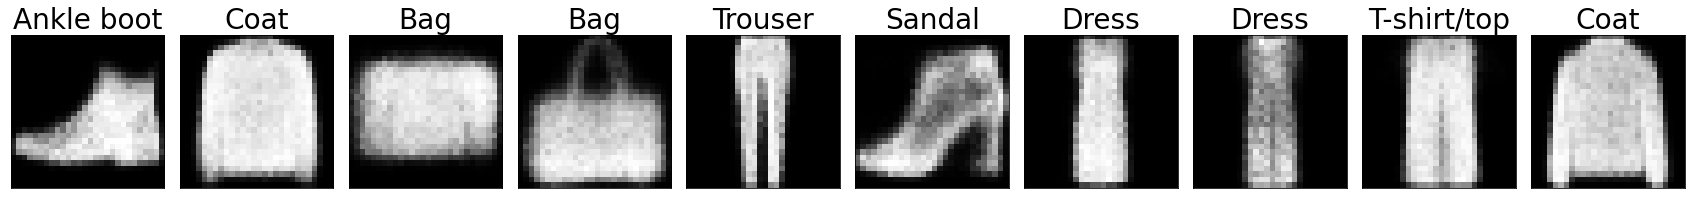



EPOCH: 4; Train elbo (-loss): -245.09317016601562;Validation elbo (-loss): -246.2395477294922


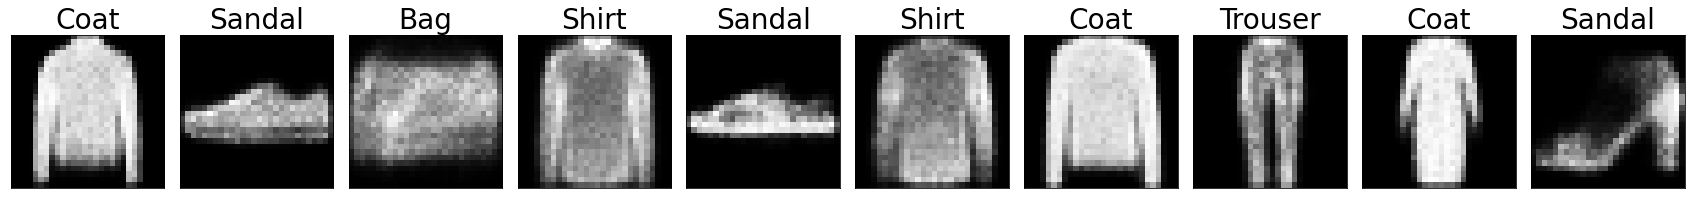

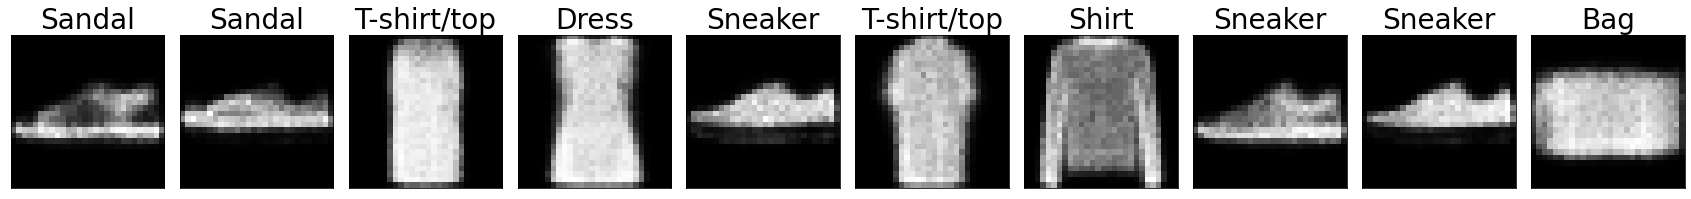



EPOCH: 5; Train elbo (-loss): -243.4900360107422;Validation elbo (-loss): -244.2273406982422


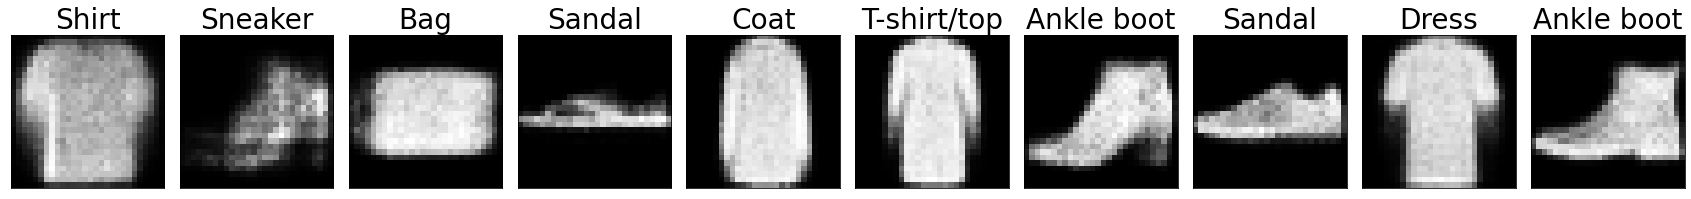

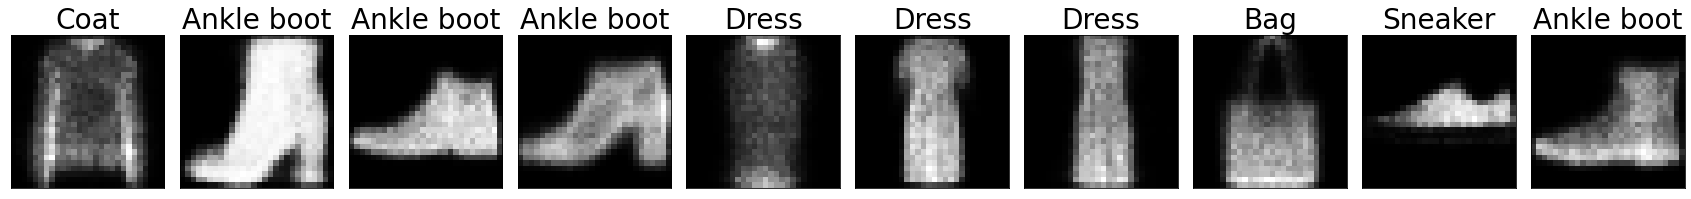

KeyboardInterrupt: ignored

In [28]:
vae10, params10, training_stats10 = train(
    vae_fn_10latents, num_epochs=10)

In [ ]:
#@title Training Curves
plot_stats(training_stats10, use_first=True)

In [ ]:
#@title Reconstructions { run: "auto" }
visualize = 'mean_image' #@param ["mean_image", "sampled_image"] 

see_reconstructions(vae10, params10, visualize, rng_seq)


In [ ]:
#@title Samples
mean_image, _ = vae10.apply.sample(params10, next(rng_seq), 40)
for i in range(4):
  gallery(mean_image[(i*10):])


## Latent Space Exploration


We trained a 10-dimensional latent space. Humans are not great at seeing 10D. We show

* per-latent statistics,
* pairwise statistics,
* t-SNE.

Latents will be coloured by class for t-SNE.


In [ ]:
zs, z_means, z_stddevs, labels = get_latents(
    vae10, params10, a_valid_ds, num_batches=8)
latent_dim = z_means.shape[-1]

z_means.shape

In [ ]:
#@title Latent Distributions
df_zs = pd.DataFrame(z_means)

pairplot = sns.pairplot(df_zs)
pairplot.set(xlim=(-3,3), ylim = (-3,3))

In [ ]:
tsne = sklearn.manifold.TSNE(init='pca')
tsne_embedded = tsne.fit_transform(z_means)

In [ ]:
#@title T-SNE of patents
plt.figure(figsize=(9, 9))
for yy in range(10):
  plt.scatter(
      tsne_embedded[labels==yy][:, 0], tsne_embedded[labels==yy][:, 1],
      label=CLASS_LABELS[yy], s=10)
plt.legend()

plt.scatter([0],[0], marker="x", s=150, color="black", linewidth=3)
plt.axis('square');
plt.title("t-SNE projection of latents")


We have achieved better overall performance by using a more powerful model. Our reconstructions are fairly decent but our samples could probably be improved.

How could we go about this? 

## $\beta$-VAE

Trading off the reconstruction and kl terms by adding a multiplier:

<center><img src="https://screenshot.googleplex.com/8iEM5gqKxwPjAqE.png" /> </center>

What would you expect for very high and very low $\beta$s?

In [ ]:
def beta_elbo(
    beta: jnp.ndarray, x: jnp.ndarray, logits: jnp.ndarray, 
    mean: jnp.ndarray, stddev: jnp.ndarray
) -> jnp.ndarray:
    """Calculate the ELBO.
    
    Args:
      beta: the scalar on the KL term.
      x: data whose likelihood we are interested in.
      logits: the logodds (logits) of the decoded distribution from the model.
      mean: mean of the q(z|x).
      stddev: stddev of the q(z|x).
 
    Returns:
      The beta-adjusted ELBO, log_likelihood and kl averaged over the batch.
    """
    log_likelihood = -binary_cross_entropy(x, logits)
    kl = kl_gaussian(mean, stddev**2)
    elbo = log_likelihood - beta*kl

    return jnp.mean(elbo), jnp.mean(log_likelihood), jnp.mean(kl)

In [ ]:
TRAIN_SET_SIZE = 60000
TEST_SET_SIZE = 10000
BATCH_SIZE = 128


We will use a latent dimension of 10 for these runs.


In [ ]:
def beta_training(beta, num_epochs=15):
  train_ds = iter(load_dataset(tfds.Split.TRAIN, BATCH_SIZE))
  valid_all_ds = iter(load_dataset(tfds.Split.TEST, TEST_SET_SIZE))
  # IMPORTANT! Normally you would use a different validation and test set;
  # This dataset does not have an explicit VALIDATION split; some of the
  # training set should be used for this.

  rng_seq = hk.PRNGSequence(42)
  optimizer = optax.adam(1e-4)
  vae = hk.multi_transform(vae_fn_10latents)
  params = vae.init(next(rng_seq), jnp.zeros((1, *MNIST_IMAGE_SHAPE)))
  opt_state = optimizer.init(params)

  @jax.jit
  def elbo_fn(params: hk.Params, rng_key: PRNGKey, batch: Batch) -> jnp.ndarray:
      """Return ELBO and its components"""
      images = batch["image"]
      output = vae.apply.reconstruct(params, rng_key, images)
      return beta_elbo(beta, images, output.logits, output.mean, output.stddev)

  @jax.jit
  def update(
      params: hk.Params, rng_key: PRNGKey, opt_state: OptState,  batch: Batch
  ) -> Tuple[hk.Params, OptState]:
    """Single update step."""
    def _just_loss(params, rng_key, batch):
      # NOTE the negative on the elbo!
      return -elbo_fn(params, rng_key, batch)[0]

    grads = jax.grad(_just_loss)(params, rng_key, batch)
    elbo, ll, kl = elbo_fn(params, rng_key, batch)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, elbo, ll, kl


  training_stats = defaultdict(list)
  for epoch in range(num_epochs+1):

    if epoch > 0:
      # Collect stats on an untrained model, so do not train.
      elbs, lls, kls = [], [], []
      for _ in range(TRAIN_SET_SIZE // BATCH_SIZE):
        batch = next(train_ds)
        # Binarize like in https://github.com/google/jax/blob/master/examples/mnist_vae.py
        batch['image'] = jax.random.bernoulli(next(rng_seq), batch['image'])
        params, opt_state, elb, ll, kl = update(params, next(rng_seq), opt_state, batch)
        elbs.append(elb)
        lls.append(ll)
        kls.append(kl)
      
      elb = np.array(elbs).mean()
      ll = np.array(lls).mean()
      kl = np.array(kls).mean()
    else:
      elb, ll, kl = None, None, None
  
    valid_all = next(valid_all_ds)
    valid_all['image'] = jax.random.bernoulli(next(rng_seq), valid_all['image'])
    val_elb, val_ll, val_kl = elbo_fn(params, next(rng_seq), valid_all)
    print("\n")
    print(f"EPOCH: {epoch}; Train elbo (-loss): {elb}; Validation elbo (-loss): {val_elb}")
    
    training_stats['val_elbo'].append(val_elb)
    training_stats['train_elbo'].append(elb)
    training_stats['val_kl'].append(val_kl)
    training_stats['train_kl'].append(kl)
    training_stats['val_ll'].append(val_ll)
    training_stats['train_ll'].append(ll)
    training_stats['epoch'].append(epoch)

    valid_output = vae.apply.reconstruct(
        params, next(rng_seq), valid_all["image"])
    # gallery(valid_all["image"], valid_all['label'])
    gallery(valid_output.mean_image, valid_all['label'])
    gallery(valid_output.mean_image[10:], valid_all['label'][10:])

  return vae, params, training_stats


### High Beta

In [ ]:
#@title Training
vae_high_beta, params_high_beta, training_stats = beta_training(
    beta=10, num_epochs=10)

In [ ]:
#@title Training Curves

f, ax = plt.subplots(3, 1, figsize=(11, 10))
for key, axx in zip(['elbo', 'll', 'kl'], ax.reshape(-1,)):
  axx.plot(
      training_stats['epoch'], training_stats[f'train_{key}'],
      label=f"Training {key}")
  axx.plot(
      training_stats['epoch'], training_stats[f'val_{key}'],
      label=f"Validation {key}")
  axx.set_xlabel("Training epoch")
  axx.set_ylabel(key)
  axx.legend()

In [ ]:
#@title Reconstructions
see_reconstructions(
    vae_high_beta, params_high_beta,
    'mean_image', rng_seq)


In [ ]:
#@title Samples
mean_image, _ = vae_high_beta.apply.sample(
    params_high_beta, next(rng_seq), 40)
for i in range(4):
  gallery(mean_image[(i*10):])


In [ ]:
zs, z_means, z_stddevs, labels = get_latents(
    vae_high_beta, params_high_beta, a_valid_ds, num_batches=8)
latent_dim = z_means.shape[-1]

z_means.shape

In [ ]:
#@title Latent Distributions
df_zs = pd.DataFrame(z_means)

pairplot = sns.pairplot(df_zs)
pairplot.set(xlim=(-3,3), ylim = (-3,3))

### Low Beta

In [ ]:
#@title Training
vae_low_beta, params_low_beta, training_stats = beta_training(
    beta=0.01, num_epochs=10)

In [ ]:
#@title Training Curves

f, ax = plt.subplots(3, 1, figsize=(11, 10))
for key, axx in zip(['elbo', 'll', 'kl'], ax.reshape(-1,)):
  axx.plot(
      training_stats['epoch'], training_stats[f'train_{key}'],
      label=f"Training {key}")
  axx.plot(
      training_stats['epoch'], training_stats[f'val_{key}'],
      label=f"Validation {key}")
  axx.set_xlabel("Training epoch")
  axx.set_ylabel(key)
  axx.legend()

In [ ]:
#@title Reconstructions
see_reconstructions(
    vae_low_beta, params_low_beta, 'mean_image', rng_seq)


In [ ]:
#@title Samples
mean_image, _ = vae_low_beta.apply.sample(
    params_low_beta, next(rng_seq), 40)
for i in range(4):
  gallery(mean_image[(i*10):])


In [ ]:
zs, z_means, z_stddevs, labels = get_latents(
    vae_low_beta, params_low_beta, a_valid_ds, num_batches=8)
latent_dim = z_means.shape[-1]

z_means.shape

In [ ]:
#@title Latent Distributions
df_zs = pd.DataFrame(z_means)

pairplot = sns.pairplot(df_zs)
pairplot.set(xlim=(-3,3), ylim = (-3,3))

**Exercise.** Create one figure each to compare

* reconstructions,
* samples

across the different models.